In [20]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import History

# Transfer learning

<br>

<img src="Grafika/transfer_learning.png" width="550">

**Transfer learning** (transfer "wiedzy") - wykorzystanie nauczonych przez kogoś sieci do naszego problemu. Możliwe dzięki temu, że cechy wykrywane przez sieci w głębokich warstwach mogą być uniwersalne i przydatne w różnych problemach.

### VGG16

In [22]:
from keras.applications import VGG16, InceptionV3
base_model = VGG16(weights='imagenet',include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### InceptionV3

In [23]:
inc = InceptionV3()
inc.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

# Zad
Trzeba nadać wymiar wejści anaszej sieci
```python
h,w = 150, 150
```

In [24]:
h,w = 150, 150
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

In [25]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [26]:
len(model.layers)

19

# Zad 
Zbudujmy siec z 
* VGG16 dla wejścia h,w = 150, 150
* Flatten
* Dense
* Dense

In [27]:
h,w = 150, 150
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(1, activation='sigmoid'))

model_transfer = Sequential()
model_transfer.add(model)
model_transfer.add(top_model)

model_transfer.layers[0].trainable = False

model_transfer.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 2097665   
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [28]:
# model.summary()
# top_model.summary()

# Zad
Naucz model na danych z 

https://www.microsoft.com/en-us/download/details.aspx?id=54765
 
* użyj Image Augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator

model_transfer.compile(loss='binary_crossentropy',optimizer="sgd",metrics=['accuracy'])

train_data_dir = r'C:\j_python\bootcamp_deep_learning\Dane\data\train'
validation_data_dir = r'C:\j_python\bootcamp_deep_learning\Dane\data\validation'
nb_validation_samples = 200
nb_train_samples = 50
epochs = 50
batch_size = 10

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45, 
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=(h, w), 
                                                    batch_size=batch_size, 
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(h, w), 
                                                        batch_size=batch_size,
                                                        class_mode='binary')


Found 200 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [16]:
nb_validation_samples//batch_size

20

In [18]:
history_tr_ag = History()
early_stopping = EarlyStopping(patience=3,monitor="val_loss")
model_transfer.fit_generator(train_generator, samples_per_epoch=batch_size, epochs=epochs, 
                    validation_data=validation_generator, nb_val_samples=10, callbacks=[early_stopping, history_tr_ag])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=50, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=1, validation_steps=10)`
  after removing the cwd from sys.path.


Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 0.4168 - accuracy: 0.9000 - val_loss: 0.5323 - val_accuracy: 0.6000
Epoch 2/50
1/1 [==============================] - 8s 8s/step - loss: 0.5300 - accuracy: 0.8000 - val_loss: 0.5194 - val_accuracy: 0.8000
Epoch 3/50
1/1 [==============================] - 8s 8s/step - loss: 0.5965 - accuracy: 0.7000 - val_loss: 0.5356 - val_accuracy: 0.8000
Epoch 4/50
1/1 [==============================] - 8s 8s/step - loss: 0.3608 - accuracy: 1.0000 - val_loss: 0.6014 - val_accuracy: 0.6000
Epoch 5/50
1/1 [==============================] - 8s 8s/step - loss: 0.6751 - accuracy: 0.5000 - val_loss: 0.5457 - val_accuracy: 0.7000
Epoch 6/50
1/1 [==============================] - 8s 8s/step - loss: 0.6591 - accuracy: 0.5000 - val_loss: 0.5119 - val_accuracy: 0.8000
Epoch 7/50
1/1 [==============================] - 8s 8s/step - loss: 0.4183 - accuracy: 1.0000 - val_loss: 0.5484 - val_accuracy: 0.7000
Epoch 8/50
1/1 [=========================

In [ ]:
# # model.evaluate(X_test,y_test)
# history_tr = History()
# early_stopping = EarlyStopping(patience=3,monitor="val_loss")
# model_transfer.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
# model_transfer.fit(X_train, y_train, validation_split=0.25,epochs=100,callbacks=[early_stopping, history_tr])
# model_transfer.evaluate(X_test,y_test)

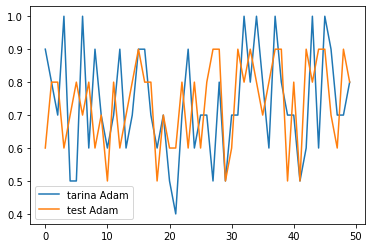

In [19]:
plt.plot(history_tr_ag.history['accuracy'], label = "tarina Adam")
plt.plot(history_tr_ag.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()